# **Library Imports**

In [3]:
!pip install --quiet comet_ml
import comet_ml
import getpass

comet_api_key = getpass.getpass('Enter key')

Enter key··········


In [4]:
from comet_ml import Experiment
import torch

from google.colab import files

import torchvision as tv
from torchvision.datasets import ImageFolder
from torch.utils.data import random_split, DataLoader, Dataset, ConcatDataset
import matplotlib.pyplot as plt

import torch.nn as nn

!pip install --quiet torchmetrics
from torchmetrics.classification import MulticlassAccuracy, MulticlassPrecision, MulticlassRecall, MulticlassF1Score, MulticlassConfusionMatrix
from tqdm import tqdm

from torch.optim import Adam, RMSprop

import numpy as np

import seaborn as sns


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 24.7 MB/s eta 0:00:00


In [5]:
experiment = comet_ml.Experiment(api_key=comet_api_key, workspace='davidafshepherd', project_name="music_genre_classification", auto_metric_logging=False, auto_output_logging=False)

COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/davidafshepherd/music-genre-classification/d91838756e214762b98511614d415b65



In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# **Download dataset from Kaggle**

In [ ]:
# Upload kaggle.json
files.upload()

In [8]:
# Move kaggle.json to correct location
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [9]:
# Download dataset
!kaggle datasets download andradaolteanu/gtzan-dataset-music-genre-classification

Dataset URL: https://www.kaggle.com/datasets/andradaolteanu/gtzan-dataset-music-genre-classification
License(s): other
 97% 1.17G/1.21G [00:14<00:00, 157MB/s]
100% 1.21G/1.21G [00:15<00:00, 86.2MB/s]


In [10]:
#Unzip dataset
!unzip gtzan-dataset-music-genre-classification.zip -d gtzan

Archive:  gtzan-dataset-music-genre-classification.zip
  inflating: gtzan/Data/features_30_sec.csv  
  inflating: gtzan/Data/features_3_sec.csv  
  inflating: gtzan/Data/genres_original/blues/blues.00000.wav  
  inflating: gtzan/Data/genres_original/blues/blues.00001.wav  
  inflating: gtzan/Data/genres_original/blues/blues.00002.wav  
  inflating: gtzan/Data/genres_original/blues/blues.00003.wav  
  inflating: gtzan/Data/genres_original/blues/blues.00004.wav  
  inflating: gtzan/Data/genres_original/blues/blues.00005.wav  
  inflating: gtzan/Data/genres_original/blues/blues.00006.wav  
  inflating: gtzan/Data/genres_original/blues/blues.00007.wav  
  inflating: gtzan/Data/genres_original/blues/blues.00008.wav  
  inflating: gtzan/Data/genres_original/blues/blues.00009.wav  
  inflating: gtzan/Data/genres_original/blues/blues.00010.wav  
  inflating: gtzan/Data/genres_original/blues/blues.00011.wav  
  inflating: gtzan/Data/genres_original/blues/blues.00012.wav  
  inflating: gtzan/Dat

# **Image pipeline**

In [51]:
# Image transform: resize to 180×180 & convert to tensor
transform = tv.transforms.Compose([tv.transforms.Resize((180, 180)), tv.transforms.ToTensor()])

In [52]:
# GTZAN image dataset
dataset = ImageFolder(root='/content/gtzan/Data/images_original', transform=transform)

In [53]:
# Define train, val and test set sizes
num_imgs = len(dataset)
train_size  = int(0.7 * num_imgs)
val_size = int(0.2 * num_imgs)
test_size = num_imgs - train_size - val_size

In [54]:
# Randomly split the dataset into train, val and test sets
train_imgs, val_imgs, test_imgs = random_split(dataset, [train_size, val_size, test_size])

In [55]:
# Image DataLoaders: batch=32, shuffle only for training
train_loader = DataLoader(train_imgs, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_imgs, batch_size=32, shuffle=False, num_workers=2)
test_loader = DataLoader(test_imgs, batch_size=32, shuffle=False, num_workers=2)

In [56]:
# Get first train batch and its labels
itr = iter(train_loader)
batch, labels = next(itr)

# Print batch shape and labels shape
print(f'Data shape: {batch.shape}')
print(f'Label shape: {labels.shape}')

Data shape: torch.Size([32, 3, 180, 180])
Label shape: torch.Size([32])


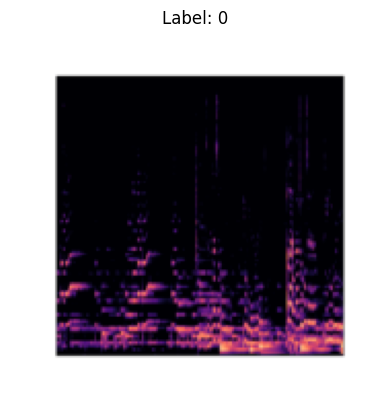

In [57]:
# Convert first image in batch to PIL image
T = tv.transforms.ToPILImage()
img = T(batch[0])

# Plot image and its label
plt.imshow(img)
plt.title(f'Label: {labels[0].item()}')
plt.axis('off')
plt.show()

# **Network Architectures (Net 1, Net2, Net3, Net4)**

In [58]:
# Fully Connected Network
class Net1(nn.Module):
  def __init__(self, fc1_features, fc2_features):
    super().__init__()
    self.net = nn.Sequential(nn.Flatten(start_dim=1),                                           # Flatten input
                             nn.Linear(in_features=3*180*180, out_features=fc1_features),       # Fully-Connected Layer
                             nn.ReLU(),                                                         # ReLU Activation Function
                             nn.Linear(in_features=fc1_features, out_features=fc2_features),    # Fully-Connected Layer
                             nn.ReLU(),                                                         # ReLU Activation Function
                             nn.Linear(in_features=fc2_features, out_features=10))              # Fully-Connected Layer

  def forward(self, x):
    return self.net(x)

In [59]:
# Convolutional Block
class Net2Block(nn.Module):
  def __init__(self, input_channels, conv1_channels, conv2_channels):
    super().__init__()
    self.block = nn.Sequential(nn.Conv2d(in_channels=input_channels, out_channels=conv1_channels, kernel_size=3),     # Convolutional Layer
                               nn.ReLU(),                                                                             # ReLU Activation Function
                               nn.Conv2d(in_channels=conv1_channels, out_channels=conv2_channels, kernel_size=3),     # Convolutional Layer
                               nn.ReLU(),                                                                             # ReLU Activation Function
                               nn.MaxPool2d(kernel_size=2))                                                           # Max Pooling Layer

  def forward(self, x):
    return self.block(x)


# Convolutional Network
class Net2(nn.Module):
  def __init__(self, conv1_channels, conv2_channels, conv3_channels, conv4_channels):
    super().__init__()
    self.net = nn.Sequential(Net2Block(3, conv1_channels, conv2_channels),                                          # Convolutional Block
                             Net2Block(conv2_channels, conv3_channels, conv4_channels),                             # Convolutional Block
                             nn.Flatten(),                                                                          # Flatten input
                             nn.Linear(in_features=conv4_channels*42*42, out_features=256),                         # Fully-Connected Layer
                             nn.ReLU(),                                                                             # ReLU Activation Function
                             nn.Linear(in_features=256, out_features=10))                                           # Fully-Connected Layer

  def forward(self, x):
    return self.net(x)

In [60]:
# Convolutional Block with Batch Normalisation
class Net3Block(nn.Module):
  def __init__(self, input_channels, conv1_channels, conv2_channels):
    super().__init__()
    self.block = nn.Sequential(nn.Conv2d(in_channels=input_channels, out_channels=conv1_channels, kernel_size=3),     # Convolutional Layer
                               nn.BatchNorm2d(conv1_channels),                                                        # Batch Normalisation Layer
                               nn.ReLU(),                                                                             # ReLU Activation Function
                               nn.Conv2d(in_channels=conv1_channels, out_channels=conv2_channels, kernel_size=3),     # Convolutional Layer
                               nn.BatchNorm2d(conv2_channels),                                                        # Batch Normalisation Layer
                               nn.ReLU(),                                                                             # ReLU Activation Function
                               nn.MaxPool2d(kernel_size=2))                                                           # Max Pooling Layer

  def forward(self, x):
    return self.block(x)


# Convolutional Network with Batch Normalisation
class Net3(nn.Module):
  def __init__(self, conv1_channels, conv2_channels, conv3_channels, conv4_channels):
    super().__init__()
    self.net = nn.Sequential(Net3Block(3, conv1_channels, conv2_channels),                                          # Convolutional Block
                             Net3Block(conv2_channels, conv3_channels, conv4_channels),                             # Convolutional Block
                             nn.Flatten(),                                                                          # Flatten input
                             nn.Linear(in_features=conv4_channels*42*42, out_features=256),                         # Fully-Connected Layer
                             nn.ReLU(),                                                                             # ReLU Activation Function
                             nn.Linear(in_features=256, out_features=10))                                           # Fully-Connected Layer

  def forward(self, x):
    return self.net(x)

# **Train & Evaluate Functions**

In [61]:
# Compute loss and accuracy for a single batch
def accuracy(model, batch, loss_fn, device):
  # Accuracy metric for 10 classes
  acc = MulticlassAccuracy(10).to(device)

  # Unpack batch into images and labels
  imgs, labels = batch
  imgs, labels = imgs.to(device), labels.to(device)

  # Model predictions and predicted classes
  outputs = model(imgs)
  _, pred = torch.max(outputs, dim=1)

  # Compute loss and update accuracy
  loss = loss_fn(outputs, labels)
  acc.update(pred, labels)

  return loss, acc.compute().item()

In [62]:
# Evaluate the model over the given data loader
@torch.no_grad()
def evaluate(model, loader, loss_fn, device):
  # Set model to eval mode
  model.eval()

  # Compute loss and accuracy for each batch in the data loader
  crit = [accuracy(model, batch, loss_fn, device) for batch in loader]
  crit = torch.tensor(crit)

  # Compute mean loss and mean accuracy across all batches
  m = crit.mean(dim=0)
  loss = m[0]
  acc = m[1]

  return loss, acc

In [63]:
# Train the model and evaluate after each epoch
def train(model, loader_train, loader_val, optimizer, loss_fn, epochs, trigger, device):
  # Move model to device
  model.to(device)

  # Training history
  history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

  # Early stopping
  es = EarlyStopping()

  # Iterate through each epoch
  for epoch in range(epochs):
    # Create a progress bar for the training loop
    loop = tqdm(loader_train)
    loop.set_description(f'Epoch [{epoch+1}/{epochs}]')

    # Set model to eval mode and initialise epoch loss
    model.train()
    epoch_loss = 0.0

    # Iterate through each batch
    for (imgs, labels) in loop:
      # Set the gradients from the previous step to 0
      optimizer.zero_grad()

      # Forward pass through the model
      imgs, labels = imgs.to(device), labels.to(device)
      outputs = model(imgs)

      # Compute and backpropagate the loss
      loss = loss_fn(outputs,labels)
      loss.backward()

      # Update model parameters
      optimizer.step()

      # Smooth the loss using exponential moving average for better progress bar readability
      epoch_loss = 0.9 * epoch_loss + 0.1 * loss.item()
      loop.set_postfix(loss=epoch_loss)

    # Evaluate model performance on training and validation sets
    train_loss, train_acc  = evaluate(model, loader_train, loss_fn, device)
    val_loss, val_acc = evaluate(model, loader_val, loss_fn, device)

    # Save model performance
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)

    # Print model performance
    print('Train: loss = {:.4f}, accuracy = {:.4f}'.format(train_loss, train_acc))
    print('Valid: loss = {:.4f}, accuracy = {:.4f}'.format(val_loss, val_acc))

    # Check if early stopping is required
    if es(val_loss) and trigger:
      return history

  return history

In [64]:
# EarlyStopping stops training if the loss doesn't improve after a set number of epochs
class EarlyStopping():
  def __init__(self, patience=4, tolerance=0):
    self.patience = patience                        # Epochs to wait after no improvement
    self.tolerance = tolerance                      # Minimum loss improvement required

    self.min_loss = float('inf')                    # Best loss seen so far
    self.count = 0                                  # Epochs without sufficient improvement

  def __call__(self, loss):
    # Check if loss improved
    if loss<self.min_loss:
      self.count = 0
      self.min_loss = loss
      return False

    # Check if loss worsened beyond tolerance
    elif loss > self.min_loss + self.tolerance:
      self.count += 1
      if self.count > self.patience:
        return True

    return False

# **Model Training & Validation (Net 1, Net2, Net3, Net4)**

In [65]:
# Loss function
loss_fn = nn.CrossEntropyLoss()

In [66]:
# Train and validate Net1
print(f'\nTraining Net1')
net1 = Net1(fc1_features=256, fc2_features=128)
optimizer = Adam(net1.parameters(), lr=0.0001)
train(net1, train_loader, val_loader, optimizer, loss_fn, 50, False, device)
net1_val_loss, net1_val_acc = evaluate(net1, val_loader, loss_fn, device)


Training Net1


Epoch [1/50]: 100%|██████████| 22/22 [00:02<00:00,  8.86it/s, loss=2]


Train: loss = 2.1058, accuracy = 0.1672
Valid: loss = 2.1773, accuracy = 0.1724


Epoch [2/50]: 100%|██████████| 22/22 [00:03<00:00,  6.52it/s, loss=1.87]


Train: loss = 2.1248, accuracy = 0.2032
Valid: loss = 2.2989, accuracy = 0.1845


Epoch [3/50]: 100%|██████████| 22/22 [00:02<00:00,  8.90it/s, loss=1.82]


Train: loss = 1.9560, accuracy = 0.2562
Valid: loss = 2.0573, accuracy = 0.2306


Epoch [4/50]: 100%|██████████| 22/22 [00:03<00:00,  7.14it/s, loss=1.77]


Train: loss = 1.9566, accuracy = 0.2541
Valid: loss = 2.1060, accuracy = 0.2583


Epoch [5/50]: 100%|██████████| 22/22 [00:02<00:00,  8.94it/s, loss=1.74]


Train: loss = 1.8758, accuracy = 0.3022
Valid: loss = 2.0389, accuracy = 0.2633


Epoch [6/50]: 100%|██████████| 22/22 [00:02<00:00,  8.48it/s, loss=1.67]


Train: loss = 1.8425, accuracy = 0.3687
Valid: loss = 2.0196, accuracy = 0.2634


Epoch [7/50]: 100%|██████████| 22/22 [00:02<00:00,  8.85it/s, loss=1.63]


Train: loss = 1.8090, accuracy = 0.3760
Valid: loss = 1.9717, accuracy = 0.2910


Epoch [8/50]: 100%|██████████| 22/22 [00:02<00:00,  8.87it/s, loss=1.59]


Train: loss = 1.7294, accuracy = 0.3659
Valid: loss = 1.9053, accuracy = 0.3226


Epoch [9/50]: 100%|██████████| 22/22 [00:02<00:00,  8.94it/s, loss=1.54]


Train: loss = 1.7194, accuracy = 0.4290
Valid: loss = 1.8969, accuracy = 0.3298


Epoch [10/50]: 100%|██████████| 22/22 [00:02<00:00,  8.87it/s, loss=1.52]


Train: loss = 1.6528, accuracy = 0.4115
Valid: loss = 1.8792, accuracy = 0.3163


Epoch [11/50]: 100%|██████████| 22/22 [00:02<00:00,  8.98it/s, loss=1.47]


Train: loss = 1.6369, accuracy = 0.3921
Valid: loss = 1.9110, accuracy = 0.2963


Epoch [12/50]: 100%|██████████| 22/22 [00:02<00:00,  8.90it/s, loss=1.47]


Train: loss = 1.5954, accuracy = 0.4437
Valid: loss = 1.8619, accuracy = 0.3388


Epoch [13/50]: 100%|██████████| 22/22 [00:02<00:00,  8.02it/s, loss=1.45]


Train: loss = 1.5657, accuracy = 0.4395
Valid: loss = 1.8063, accuracy = 0.3783


Epoch [14/50]: 100%|██████████| 22/22 [00:02<00:00,  8.92it/s, loss=1.37]


Train: loss = 1.4838, accuracy = 0.5296
Valid: loss = 1.8092, accuracy = 0.3719


Epoch [15/50]: 100%|██████████| 22/22 [00:02<00:00,  7.61it/s, loss=1.33]


Train: loss = 1.4338, accuracy = 0.5494
Valid: loss = 1.7659, accuracy = 0.3466


Epoch [16/50]: 100%|██████████| 22/22 [00:02<00:00,  8.95it/s, loss=1.3]


Train: loss = 1.3812, accuracy = 0.5662
Valid: loss = 1.7343, accuracy = 0.3966


Epoch [17/50]: 100%|██████████| 22/22 [00:03<00:00,  6.86it/s, loss=1.28]


Train: loss = 1.3417, accuracy = 0.5673
Valid: loss = 1.6831, accuracy = 0.3307


Epoch [18/50]: 100%|██████████| 22/22 [00:02<00:00,  8.92it/s, loss=1.22]


Train: loss = 1.3681, accuracy = 0.5098
Valid: loss = 1.8408, accuracy = 0.3095


Epoch [19/50]: 100%|██████████| 22/22 [00:03<00:00,  6.29it/s, loss=1.19]


Train: loss = 1.3315, accuracy = 0.5170
Valid: loss = 1.7475, accuracy = 0.3483


Epoch [20/50]: 100%|██████████| 22/22 [00:02<00:00,  8.89it/s, loss=1.16]


Train: loss = 1.2556, accuracy = 0.5885
Valid: loss = 1.6976, accuracy = 0.4017


Epoch [21/50]: 100%|██████████| 22/22 [00:03<00:00,  5.97it/s, loss=1.14]


Train: loss = 1.2106, accuracy = 0.6732
Valid: loss = 1.6940, accuracy = 0.4384


Epoch [22/50]: 100%|██████████| 22/22 [00:02<00:00,  8.85it/s, loss=1.13]


Train: loss = 1.1716, accuracy = 0.7009
Valid: loss = 1.6625, accuracy = 0.4368


Epoch [23/50]: 100%|██████████| 22/22 [00:03<00:00,  6.17it/s, loss=1.1]


Train: loss = 1.1804, accuracy = 0.6281
Valid: loss = 1.7632, accuracy = 0.3946


Epoch [24/50]: 100%|██████████| 22/22 [00:02<00:00,  8.87it/s, loss=1.08]


Train: loss = 1.1363, accuracy = 0.6554
Valid: loss = 1.6490, accuracy = 0.4233


Epoch [25/50]: 100%|██████████| 22/22 [00:03<00:00,  6.46it/s, loss=1.09]


Train: loss = 1.1136, accuracy = 0.6839
Valid: loss = 1.7454, accuracy = 0.4030


Epoch [26/50]: 100%|██████████| 22/22 [00:02<00:00,  8.62it/s, loss=1.03]


Train: loss = 1.1223, accuracy = 0.6534
Valid: loss = 1.7374, accuracy = 0.3881


Epoch [27/50]: 100%|██████████| 22/22 [00:03<00:00,  7.13it/s, loss=0.986]


Train: loss = 1.1263, accuracy = 0.6459
Valid: loss = 1.6747, accuracy = 0.3921


Epoch [28/50]: 100%|██████████| 22/22 [00:02<00:00,  8.90it/s, loss=1.02]


Train: loss = 1.1022, accuracy = 0.6269
Valid: loss = 1.7269, accuracy = 0.4056


Epoch [29/50]: 100%|██████████| 22/22 [00:02<00:00,  8.19it/s, loss=0.95]


Train: loss = 0.9912, accuracy = 0.6991
Valid: loss = 1.6735, accuracy = 0.4034


Epoch [30/50]: 100%|██████████| 22/22 [00:02<00:00,  8.91it/s, loss=0.943]


Train: loss = 1.0492, accuracy = 0.6463
Valid: loss = 1.7077, accuracy = 0.3660


Epoch [31/50]: 100%|██████████| 22/22 [00:02<00:00,  8.47it/s, loss=0.923]


Train: loss = 0.9428, accuracy = 0.7106
Valid: loss = 1.6318, accuracy = 0.4054


Epoch [32/50]: 100%|██████████| 22/22 [00:02<00:00,  8.87it/s, loss=0.888]


Train: loss = 1.0638, accuracy = 0.6614
Valid: loss = 1.7920, accuracy = 0.3610


Epoch [33/50]: 100%|██████████| 22/22 [00:02<00:00,  8.89it/s, loss=0.883]


Train: loss = 0.9685, accuracy = 0.6791
Valid: loss = 1.8458, accuracy = 0.3465


Epoch [34/50]: 100%|██████████| 22/22 [00:02<00:00,  8.88it/s, loss=0.806]


Train: loss = 0.8762, accuracy = 0.7180
Valid: loss = 1.6459, accuracy = 0.4273


Epoch [35/50]: 100%|██████████| 22/22 [00:02<00:00,  8.86it/s, loss=0.775]


Train: loss = 0.8655, accuracy = 0.7724
Valid: loss = 1.7037, accuracy = 0.4498


Epoch [36/50]: 100%|██████████| 22/22 [00:02<00:00,  8.58it/s, loss=0.797]


Train: loss = 0.8525, accuracy = 0.7727
Valid: loss = 1.6030, accuracy = 0.4316


Epoch [37/50]: 100%|██████████| 22/22 [00:02<00:00,  8.79it/s, loss=0.709]


Train: loss = 0.8182, accuracy = 0.8164
Valid: loss = 1.5967, accuracy = 0.4019


Epoch [38/50]: 100%|██████████| 22/22 [00:02<00:00,  8.84it/s, loss=0.755]


Train: loss = 0.7593, accuracy = 0.8346
Valid: loss = 1.6149, accuracy = 0.4396


Epoch [39/50]: 100%|██████████| 22/22 [00:02<00:00,  8.89it/s, loss=0.724]


Train: loss = 0.7886, accuracy = 0.7694
Valid: loss = 1.7032, accuracy = 0.3954


Epoch [40/50]: 100%|██████████| 22/22 [00:02<00:00,  8.14it/s, loss=0.699]


Train: loss = 0.7541, accuracy = 0.8383
Valid: loss = 1.6958, accuracy = 0.4011


Epoch [41/50]: 100%|██████████| 22/22 [00:02<00:00,  8.49it/s, loss=0.699]


Train: loss = 0.7407, accuracy = 0.7743
Valid: loss = 1.7207, accuracy = 0.3773


Epoch [42/50]: 100%|██████████| 22/22 [00:02<00:00,  7.37it/s, loss=0.646]


Train: loss = 0.6906, accuracy = 0.8250
Valid: loss = 1.6538, accuracy = 0.4471


Epoch [43/50]: 100%|██████████| 22/22 [00:02<00:00,  8.91it/s, loss=0.674]


Train: loss = 0.6353, accuracy = 0.8811
Valid: loss = 1.6094, accuracy = 0.4932


Epoch [44/50]: 100%|██████████| 22/22 [00:03<00:00,  6.44it/s, loss=0.636]


Train: loss = 0.6364, accuracy = 0.8612
Valid: loss = 1.6264, accuracy = 0.4435


Epoch [45/50]: 100%|██████████| 22/22 [00:02<00:00,  8.84it/s, loss=0.597]


Train: loss = 0.6590, accuracy = 0.8389
Valid: loss = 1.5691, accuracy = 0.4416


Epoch [46/50]: 100%|██████████| 22/22 [00:03<00:00,  5.97it/s, loss=0.587]


Train: loss = 0.5931, accuracy = 0.8670
Valid: loss = 1.6580, accuracy = 0.4545


Epoch [47/50]: 100%|██████████| 22/22 [00:02<00:00,  8.88it/s, loss=0.574]


Train: loss = 0.6418, accuracy = 0.8326
Valid: loss = 1.6888, accuracy = 0.4428


Epoch [48/50]: 100%|██████████| 22/22 [00:03<00:00,  6.54it/s, loss=0.568]


Train: loss = 0.7298, accuracy = 0.7524
Valid: loss = 1.8396, accuracy = 0.3899


Epoch [49/50]: 100%|██████████| 22/22 [00:02<00:00,  8.80it/s, loss=0.538]


Train: loss = 0.6150, accuracy = 0.8602
Valid: loss = 1.7347, accuracy = 0.4374


Epoch [50/50]: 100%|██████████| 22/22 [00:02<00:00,  7.67it/s, loss=0.535]


Train: loss = 0.5242, accuracy = 0.9183
Valid: loss = 1.6697, accuracy = 0.4341


In [67]:
# Train and validate Net2
print(f'\nTraining Net2')
net2 = Net2(conv1_channels=16, conv2_channels=16, conv3_channels=32, conv4_channels=32)
optimizer = Adam(net2.parameters(), lr=0.0001)
train(net2, train_loader, val_loader, optimizer, loss_fn, 50, False, device)
net2_val_loss, net2_val_acc = evaluate(net2, val_loader, loss_fn, device)


Training Net2


Epoch [1/50]: 100%|██████████| 22/22 [00:03<00:00,  5.78it/s, loss=2.08]


Train: loss = 2.2972, accuracy = 0.0985
Valid: loss = 2.3065, accuracy = 0.1000


Epoch [2/50]: 100%|██████████| 22/22 [00:03<00:00,  5.99it/s, loss=2.07]


Train: loss = 2.2795, accuracy = 0.1446
Valid: loss = 2.2986, accuracy = 0.1405


Epoch [3/50]: 100%|██████████| 22/22 [00:02<00:00,  8.35it/s, loss=2.04]


Train: loss = 2.2317, accuracy = 0.2102
Valid: loss = 2.2470, accuracy = 0.2024


Epoch [4/50]: 100%|██████████| 22/22 [00:03<00:00,  5.80it/s, loss=1.95]


Train: loss = 2.1167, accuracy = 0.2116
Valid: loss = 2.1761, accuracy = 0.2056


Epoch [5/50]: 100%|██████████| 22/22 [00:02<00:00,  7.86it/s, loss=1.87]


Train: loss = 2.0322, accuracy = 0.2113
Valid: loss = 2.1001, accuracy = 0.1664


Epoch [6/50]: 100%|██████████| 22/22 [00:03<00:00,  6.06it/s, loss=1.79]


Train: loss = 1.9706, accuracy = 0.2878
Valid: loss = 2.0994, accuracy = 0.2713


Epoch [7/50]: 100%|██████████| 22/22 [00:02<00:00,  8.09it/s, loss=1.8]


Train: loss = 1.9594, accuracy = 0.2737
Valid: loss = 2.0754, accuracy = 0.2040


Epoch [8/50]: 100%|██████████| 22/22 [00:03<00:00,  6.07it/s, loss=1.73]


Train: loss = 1.9133, accuracy = 0.3534
Valid: loss = 2.0042, accuracy = 0.3207


Epoch [9/50]: 100%|██████████| 22/22 [00:02<00:00,  8.32it/s, loss=1.71]


Train: loss = 1.8783, accuracy = 0.3149
Valid: loss = 2.0207, accuracy = 0.2476


Epoch [10/50]: 100%|██████████| 22/22 [00:03<00:00,  5.97it/s, loss=1.68]


Train: loss = 1.8425, accuracy = 0.3252
Valid: loss = 1.9983, accuracy = 0.2568


Epoch [11/50]: 100%|██████████| 22/22 [00:02<00:00,  8.13it/s, loss=1.68]


Train: loss = 1.8150, accuracy = 0.3417
Valid: loss = 1.9676, accuracy = 0.2805


Epoch [12/50]: 100%|██████████| 22/22 [00:03<00:00,  6.00it/s, loss=1.65]


Train: loss = 1.8013, accuracy = 0.3530
Valid: loss = 1.9155, accuracy = 0.3088


Epoch [13/50]: 100%|██████████| 22/22 [00:02<00:00,  8.01it/s, loss=1.6]


Train: loss = 1.7564, accuracy = 0.3691
Valid: loss = 1.9186, accuracy = 0.3200


Epoch [14/50]: 100%|██████████| 22/22 [00:03<00:00,  6.31it/s, loss=1.56]


Train: loss = 1.7229, accuracy = 0.3858
Valid: loss = 1.8775, accuracy = 0.3168


Epoch [15/50]: 100%|██████████| 22/22 [00:02<00:00,  8.15it/s, loss=1.57]


Train: loss = 1.6924, accuracy = 0.3928
Valid: loss = 1.9091, accuracy = 0.3035


Epoch [16/50]: 100%|██████████| 22/22 [00:03<00:00,  6.37it/s, loss=1.55]


Train: loss = 1.6499, accuracy = 0.4618
Valid: loss = 1.8640, accuracy = 0.3484


Epoch [17/50]: 100%|██████████| 22/22 [00:02<00:00,  8.10it/s, loss=1.51]


Train: loss = 1.6025, accuracy = 0.4271
Valid: loss = 1.7952, accuracy = 0.3330


Epoch [18/50]: 100%|██████████| 22/22 [00:03<00:00,  6.65it/s, loss=1.45]


Train: loss = 1.5503, accuracy = 0.4589
Valid: loss = 1.7684, accuracy = 0.3678


Epoch [19/50]: 100%|██████████| 22/22 [00:02<00:00,  8.03it/s, loss=1.4]


Train: loss = 1.5464, accuracy = 0.4378
Valid: loss = 1.8210, accuracy = 0.3391


Epoch [20/50]: 100%|██████████| 22/22 [00:03<00:00,  6.98it/s, loss=1.4]


Train: loss = 1.4726, accuracy = 0.4956
Valid: loss = 1.7373, accuracy = 0.3879


Epoch [21/50]: 100%|██████████| 22/22 [00:02<00:00,  8.31it/s, loss=1.36]


Train: loss = 1.5021, accuracy = 0.4498
Valid: loss = 1.8053, accuracy = 0.3664


Epoch [22/50]: 100%|██████████| 22/22 [00:03<00:00,  6.98it/s, loss=1.34]


Train: loss = 1.4261, accuracy = 0.5162
Valid: loss = 1.7165, accuracy = 0.3674


Epoch [23/50]: 100%|██████████| 22/22 [00:02<00:00,  8.24it/s, loss=1.28]


Train: loss = 1.4299, accuracy = 0.5048
Valid: loss = 1.6671, accuracy = 0.3908


Epoch [24/50]: 100%|██████████| 22/22 [00:03<00:00,  6.94it/s, loss=1.29]


Train: loss = 1.4793, accuracy = 0.3865
Valid: loss = 1.8978, accuracy = 0.3165


Epoch [25/50]: 100%|██████████| 22/22 [00:02<00:00,  8.21it/s, loss=1.24]


Train: loss = 1.2981, accuracy = 0.5428
Valid: loss = 1.6383, accuracy = 0.4008


Epoch [26/50]: 100%|██████████| 22/22 [00:02<00:00,  7.39it/s, loss=1.25]


Train: loss = 1.3858, accuracy = 0.4942
Valid: loss = 1.7873, accuracy = 0.3559


Epoch [27/50]: 100%|██████████| 22/22 [00:02<00:00,  8.11it/s, loss=1.17]


Train: loss = 1.2546, accuracy = 0.5841
Valid: loss = 1.6501, accuracy = 0.4490


Epoch [28/50]: 100%|██████████| 22/22 [00:02<00:00,  7.67it/s, loss=1.16]


Train: loss = 1.1859, accuracy = 0.6058
Valid: loss = 1.6201, accuracy = 0.4177


Epoch [29/50]: 100%|██████████| 22/22 [00:02<00:00,  8.33it/s, loss=1.12]


Train: loss = 1.2238, accuracy = 0.5636
Valid: loss = 1.6282, accuracy = 0.3290


Epoch [30/50]: 100%|██████████| 22/22 [00:03<00:00,  6.65it/s, loss=1.07]


Train: loss = 1.1638, accuracy = 0.5557
Valid: loss = 1.6728, accuracy = 0.4135


Epoch [31/50]: 100%|██████████| 22/22 [00:02<00:00,  8.09it/s, loss=1.04]


Train: loss = 1.1790, accuracy = 0.5865
Valid: loss = 1.7372, accuracy = 0.4076


Epoch [32/50]: 100%|██████████| 22/22 [00:03<00:00,  7.32it/s, loss=1.05]


Train: loss = 1.0571, accuracy = 0.6670
Valid: loss = 1.6205, accuracy = 0.4208


Epoch [33/50]: 100%|██████████| 22/22 [00:02<00:00,  8.01it/s, loss=0.978]


Train: loss = 1.0165, accuracy = 0.6617
Valid: loss = 1.6520, accuracy = 0.4400


Epoch [34/50]: 100%|██████████| 22/22 [00:02<00:00,  7.74it/s, loss=0.942]


Train: loss = 1.1188, accuracy = 0.6253
Valid: loss = 1.7244, accuracy = 0.4125


Epoch [35/50]: 100%|██████████| 22/22 [00:02<00:00,  8.14it/s, loss=0.973]


Train: loss = 1.0164, accuracy = 0.6493
Valid: loss = 1.6260, accuracy = 0.4463


Epoch [36/50]: 100%|██████████| 22/22 [00:02<00:00,  7.95it/s, loss=0.866]


Train: loss = 0.9113, accuracy = 0.7040
Valid: loss = 1.6189, accuracy = 0.4706


Epoch [37/50]: 100%|██████████| 22/22 [00:02<00:00,  7.96it/s, loss=0.897]


Train: loss = 0.9247, accuracy = 0.6864
Valid: loss = 1.6552, accuracy = 0.4718


Epoch [38/50]: 100%|██████████| 22/22 [00:02<00:00,  8.12it/s, loss=0.839]


Train: loss = 0.9999, accuracy = 0.6354
Valid: loss = 1.8546, accuracy = 0.4032


Epoch [39/50]: 100%|██████████| 22/22 [00:02<00:00,  8.23it/s, loss=0.816]


Train: loss = 0.8518, accuracy = 0.7038
Valid: loss = 1.6516, accuracy = 0.4926


Epoch [40/50]: 100%|██████████| 22/22 [00:02<00:00,  8.16it/s, loss=0.789]


Train: loss = 0.8260, accuracy = 0.7125
Valid: loss = 1.7252, accuracy = 0.4261


Epoch [41/50]: 100%|██████████| 22/22 [00:02<00:00,  8.16it/s, loss=0.738]


Train: loss = 0.7869, accuracy = 0.7508
Valid: loss = 1.6893, accuracy = 0.4628


Epoch [42/50]: 100%|██████████| 22/22 [00:02<00:00,  8.09it/s, loss=0.705]


Train: loss = 0.7306, accuracy = 0.7552
Valid: loss = 1.7034, accuracy = 0.4762


Epoch [43/50]: 100%|██████████| 22/22 [00:02<00:00,  8.19it/s, loss=0.649]


Train: loss = 0.6839, accuracy = 0.8088
Valid: loss = 1.6560, accuracy = 0.4759


Epoch [44/50]: 100%|██████████| 22/22 [00:02<00:00,  8.29it/s, loss=0.702]


Train: loss = 0.6862, accuracy = 0.7814
Valid: loss = 1.6833, accuracy = 0.4770


Epoch [45/50]: 100%|██████████| 22/22 [00:02<00:00,  8.04it/s, loss=0.68]


Train: loss = 0.6974, accuracy = 0.7892
Valid: loss = 1.7192, accuracy = 0.4370


Epoch [46/50]: 100%|██████████| 22/22 [00:02<00:00,  8.27it/s, loss=0.591]


Train: loss = 0.6177, accuracy = 0.7967
Valid: loss = 1.6675, accuracy = 0.4852


Epoch [47/50]: 100%|██████████| 22/22 [00:02<00:00,  8.11it/s, loss=0.588]


Train: loss = 0.6247, accuracy = 0.7926
Valid: loss = 1.7466, accuracy = 0.4467


Epoch [48/50]: 100%|██████████| 22/22 [00:02<00:00,  8.13it/s, loss=0.588]


Train: loss = 0.5799, accuracy = 0.8108
Valid: loss = 1.7902, accuracy = 0.4850


Epoch [49/50]: 100%|██████████| 22/22 [00:02<00:00,  7.94it/s, loss=0.585]


Train: loss = 0.5784, accuracy = 0.8156
Valid: loss = 1.8325, accuracy = 0.4703


Epoch [50/50]: 100%|██████████| 22/22 [00:02<00:00,  7.86it/s, loss=0.49]


Train: loss = 0.5382, accuracy = 0.8173
Valid: loss = 1.8133, accuracy = 0.4463


In [68]:
# Train and validate Net3
print(f'\nTraining Net3')
net3 = Net3(conv1_channels=32, conv2_channels=32, conv3_channels=64, conv4_channels=64)
optimizer = Adam(net3.parameters(), lr=0.0001)
train(net3, train_loader, val_loader, optimizer, loss_fn, 50, False, device)
net3_val_loss, net3_val_acc = evaluate(net3, val_loader, loss_fn, device)


Training Net3


Epoch [1/50]: 100%|██████████| 22/22 [00:03<00:00,  5.93it/s, loss=2.5]


Train: loss = 2.2477, accuracy = 0.2525
Valid: loss = 2.2696, accuracy = 0.2304


Epoch [2/50]: 100%|██████████| 22/22 [00:03<00:00,  7.15it/s, loss=1.37]


Train: loss = 1.9173, accuracy = 0.3275
Valid: loss = 2.0860, accuracy = 0.3110


Epoch [3/50]: 100%|██████████| 22/22 [00:04<00:00,  5.47it/s, loss=1.21]


Train: loss = 1.1695, accuracy = 0.6520
Valid: loss = 1.5584, accuracy = 0.4344


Epoch [4/50]: 100%|██████████| 22/22 [00:03<00:00,  7.01it/s, loss=0.964]


Train: loss = 0.9381, accuracy = 0.6961
Valid: loss = 1.4612, accuracy = 0.4858


Epoch [5/50]: 100%|██████████| 22/22 [00:04<00:00,  5.45it/s, loss=0.697]


Train: loss = 0.6256, accuracy = 0.8209
Valid: loss = 1.3302, accuracy = 0.4905


Epoch [6/50]: 100%|██████████| 22/22 [00:03<00:00,  6.82it/s, loss=0.429]


Train: loss = 0.4000, accuracy = 0.9022
Valid: loss = 1.3291, accuracy = 0.5231


Epoch [7/50]: 100%|██████████| 22/22 [00:03<00:00,  5.68it/s, loss=0.278]


Train: loss = 0.2338, accuracy = 0.9770
Valid: loss = 1.1939, accuracy = 0.6195


Epoch [8/50]: 100%|██████████| 22/22 [00:03<00:00,  7.03it/s, loss=0.189]


Train: loss = 0.1688, accuracy = 0.9886
Valid: loss = 1.2405, accuracy = 0.6146


Epoch [9/50]: 100%|██████████| 22/22 [00:02<00:00,  7.33it/s, loss=0.134]


Train: loss = 0.1106, accuracy = 0.9888
Valid: loss = 1.1951, accuracy = 0.5850


Epoch [10/50]: 100%|██████████| 22/22 [00:03<00:00,  7.06it/s, loss=0.104]


Train: loss = 0.0791, accuracy = 0.9991
Valid: loss = 1.1686, accuracy = 0.6266


Epoch [11/50]: 100%|██████████| 22/22 [00:03<00:00,  7.26it/s, loss=0.0687]


Train: loss = 0.0524, accuracy = 1.0000
Valid: loss = 1.1867, accuracy = 0.5816


Epoch [12/50]: 100%|██████████| 22/22 [00:03<00:00,  6.70it/s, loss=0.0617]


Train: loss = 0.0439, accuracy = 0.9983
Valid: loss = 1.1664, accuracy = 0.6199


Epoch [13/50]: 100%|██████████| 22/22 [00:03<00:00,  7.00it/s, loss=0.0406]


Train: loss = 0.0331, accuracy = 1.0000
Valid: loss = 1.1615, accuracy = 0.5731


Epoch [14/50]: 100%|██████████| 22/22 [00:03<00:00,  5.66it/s, loss=0.031]


Train: loss = 0.0282, accuracy = 1.0000
Valid: loss = 1.1854, accuracy = 0.6186


Epoch [15/50]: 100%|██████████| 22/22 [00:03<00:00,  7.17it/s, loss=0.0268]


Train: loss = 0.0232, accuracy = 1.0000
Valid: loss = 1.1723, accuracy = 0.6050


Epoch [16/50]: 100%|██████████| 22/22 [00:04<00:00,  5.39it/s, loss=0.0205]


Train: loss = 0.0205, accuracy = 1.0000
Valid: loss = 1.1956, accuracy = 0.6365


Epoch [17/50]: 100%|██████████| 22/22 [00:02<00:00,  7.34it/s, loss=0.0177]


Train: loss = 0.0178, accuracy = 1.0000
Valid: loss = 1.1754, accuracy = 0.6208


Epoch [18/50]: 100%|██████████| 22/22 [00:03<00:00,  5.84it/s, loss=0.0161]


Train: loss = 0.0150, accuracy = 1.0000
Valid: loss = 1.1855, accuracy = 0.6312


Epoch [19/50]: 100%|██████████| 22/22 [00:03<00:00,  7.00it/s, loss=0.0127]


Train: loss = 0.0131, accuracy = 1.0000
Valid: loss = 1.1724, accuracy = 0.6348


Epoch [20/50]: 100%|██████████| 22/22 [00:03<00:00,  7.13it/s, loss=0.0123]


Train: loss = 0.0124, accuracy = 1.0000
Valid: loss = 1.1542, accuracy = 0.6305


Epoch [21/50]: 100%|██████████| 22/22 [00:03<00:00,  7.05it/s, loss=0.0109]


Train: loss = 0.0107, accuracy = 1.0000
Valid: loss = 1.1935, accuracy = 0.6268


Epoch [22/50]: 100%|██████████| 22/22 [00:03<00:00,  7.19it/s, loss=0.00936]


Train: loss = 0.0092, accuracy = 1.0000
Valid: loss = 1.1864, accuracy = 0.5988


Epoch [23/50]: 100%|██████████| 22/22 [00:03<00:00,  6.70it/s, loss=0.00871]


Train: loss = 0.0088, accuracy = 1.0000
Valid: loss = 1.1874, accuracy = 0.5940


Epoch [24/50]: 100%|██████████| 22/22 [00:03<00:00,  7.04it/s, loss=0.0078]


Train: loss = 0.0076, accuracy = 1.0000
Valid: loss = 1.1727, accuracy = 0.6296


Epoch [25/50]: 100%|██████████| 22/22 [00:03<00:00,  5.65it/s, loss=0.00709]


Train: loss = 0.0067, accuracy = 1.0000
Valid: loss = 1.1899, accuracy = 0.6248


Epoch [26/50]: 100%|██████████| 22/22 [00:03<00:00,  7.08it/s, loss=0.0069]


Train: loss = 0.0068, accuracy = 1.0000
Valid: loss = 1.2023, accuracy = 0.6361


Epoch [27/50]: 100%|██████████| 22/22 [00:04<00:00,  5.39it/s, loss=0.0059]


Train: loss = 0.0059, accuracy = 1.0000
Valid: loss = 1.2091, accuracy = 0.6036


Epoch [28/50]: 100%|██████████| 22/22 [00:03<00:00,  7.18it/s, loss=0.00521]


Train: loss = 0.0056, accuracy = 1.0000
Valid: loss = 1.2210, accuracy = 0.5965


Epoch [29/50]: 100%|██████████| 22/22 [00:03<00:00,  5.99it/s, loss=0.00532]


Train: loss = 0.0051, accuracy = 1.0000
Valid: loss = 1.2121, accuracy = 0.5973


Epoch [30/50]: 100%|██████████| 22/22 [00:03<00:00,  7.21it/s, loss=0.0047]


Train: loss = 0.0047, accuracy = 1.0000
Valid: loss = 1.2054, accuracy = 0.6108


Epoch [31/50]: 100%|██████████| 22/22 [00:03<00:00,  7.05it/s, loss=0.00437]


Train: loss = 0.0043, accuracy = 1.0000
Valid: loss = 1.2282, accuracy = 0.5840


Epoch [32/50]: 100%|██████████| 22/22 [00:03<00:00,  6.65it/s, loss=0.00442]


Train: loss = 0.0041, accuracy = 1.0000
Valid: loss = 1.1995, accuracy = 0.6292


Epoch [33/50]: 100%|██████████| 22/22 [00:03<00:00,  7.12it/s, loss=0.00399]


Train: loss = 0.0038, accuracy = 1.0000
Valid: loss = 1.2264, accuracy = 0.5934


Epoch [34/50]: 100%|██████████| 22/22 [00:03<00:00,  7.02it/s, loss=0.00371]


Train: loss = 0.0036, accuracy = 1.0000
Valid: loss = 1.2222, accuracy = 0.6383


Epoch [35/50]: 100%|██████████| 22/22 [00:03<00:00,  7.16it/s, loss=0.00356]


Train: loss = 0.0034, accuracy = 1.0000
Valid: loss = 1.1891, accuracy = 0.6419


Epoch [36/50]: 100%|██████████| 22/22 [00:03<00:00,  5.71it/s, loss=0.00322]


Train: loss = 0.0031, accuracy = 1.0000
Valid: loss = 1.2226, accuracy = 0.6167


Epoch [37/50]: 100%|██████████| 22/22 [00:03<00:00,  7.26it/s, loss=0.0031]


Train: loss = 0.0030, accuracy = 1.0000
Valid: loss = 1.2252, accuracy = 0.6060


Epoch [38/50]: 100%|██████████| 22/22 [00:04<00:00,  5.42it/s, loss=0.00286]


Train: loss = 0.0029, accuracy = 1.0000
Valid: loss = 1.2314, accuracy = 0.6100


Epoch [39/50]: 100%|██████████| 22/22 [00:03<00:00,  7.18it/s, loss=0.00277]


Train: loss = 0.0026, accuracy = 1.0000
Valid: loss = 1.2193, accuracy = 0.6131


Epoch [40/50]: 100%|██████████| 22/22 [00:03<00:00,  5.60it/s, loss=0.00246]


Train: loss = 0.0025, accuracy = 1.0000
Valid: loss = 1.2194, accuracy = 0.6096


Epoch [41/50]: 100%|██████████| 22/22 [00:02<00:00,  7.34it/s, loss=0.00248]


Train: loss = 0.0025, accuracy = 1.0000
Valid: loss = 1.2150, accuracy = 0.6239


Epoch [42/50]: 100%|██████████| 22/22 [00:03<00:00,  6.75it/s, loss=0.00226]


Train: loss = 0.0023, accuracy = 1.0000
Valid: loss = 1.2154, accuracy = 0.6060


Epoch [43/50]: 100%|██████████| 22/22 [00:03<00:00,  7.24it/s, loss=0.00213]


Train: loss = 0.0021, accuracy = 1.0000
Valid: loss = 1.2237, accuracy = 0.6167


Epoch [44/50]: 100%|██████████| 22/22 [00:03<00:00,  7.15it/s, loss=0.00205]


Train: loss = 0.0021, accuracy = 1.0000
Valid: loss = 1.2434, accuracy = 0.6060


Epoch [45/50]: 100%|██████████| 22/22 [00:03<00:00,  6.42it/s, loss=0.00209]


Train: loss = 0.0020, accuracy = 1.0000
Valid: loss = 1.2133, accuracy = 0.6625


Epoch [46/50]: 100%|██████████| 22/22 [00:03<00:00,  7.02it/s, loss=0.00194]


Train: loss = 0.0020, accuracy = 1.0000
Valid: loss = 1.2288, accuracy = 0.6159


Epoch [47/50]: 100%|██████████| 22/22 [00:03<00:00,  5.55it/s, loss=0.00179]


Train: loss = 0.0018, accuracy = 1.0000
Valid: loss = 1.2431, accuracy = 0.6092


Epoch [48/50]: 100%|██████████| 22/22 [00:03<00:00,  7.07it/s, loss=0.00181]


Train: loss = 0.0018, accuracy = 1.0000
Valid: loss = 1.2280, accuracy = 0.6159


Epoch [49/50]: 100%|██████████| 22/22 [00:04<00:00,  5.26it/s, loss=0.00174]


Train: loss = 0.0017, accuracy = 1.0000
Valid: loss = 1.2189, accuracy = 0.6395


Epoch [50/50]: 100%|██████████| 22/22 [00:03<00:00,  7.24it/s, loss=0.00172]


Train: loss = 0.0017, accuracy = 1.0000
Valid: loss = 1.2408, accuracy = 0.6060


In [69]:
# Train and validate Net4
print(f'\nTraining Net4')
net4 = Net3(conv1_channels=16, conv2_channels=16, conv3_channels=32, conv4_channels=32)
optimizer = RMSprop(net4.parameters(), lr=0.0001)
train(net4, train_loader, val_loader, optimizer, loss_fn, 50, False, device)
net4_val_loss, net4_val_acc = evaluate(net4, val_loader, loss_fn, device)


Training Net4


Epoch [1/50]: 100%|██████████| 22/22 [00:02<00:00,  8.22it/s, loss=4.35]


Train: loss = 2.7804, accuracy = 0.1448
Valid: loss = 2.8494, accuracy = 0.1262


Epoch [2/50]: 100%|██████████| 22/22 [00:02<00:00,  8.07it/s, loss=1.85]


Train: loss = 2.5835, accuracy = 0.0949
Valid: loss = 2.8505, accuracy = 0.1024


Epoch [3/50]: 100%|██████████| 22/22 [00:02<00:00,  8.11it/s, loss=1.49]


Train: loss = 1.5959, accuracy = 0.3918
Valid: loss = 1.8108, accuracy = 0.3613


Epoch [4/50]: 100%|██████████| 22/22 [00:02<00:00,  7.95it/s, loss=1.39]


Train: loss = 1.4270, accuracy = 0.4993
Valid: loss = 1.7191, accuracy = 0.3971


Epoch [5/50]: 100%|██████████| 22/22 [00:02<00:00,  8.18it/s, loss=1.31]


Train: loss = 1.4183, accuracy = 0.4344
Valid: loss = 1.7230, accuracy = 0.3670


Epoch [6/50]: 100%|██████████| 22/22 [00:02<00:00,  7.93it/s, loss=1.17]


Train: loss = 1.1301, accuracy = 0.6352
Valid: loss = 1.5178, accuracy = 0.5241


Epoch [7/50]: 100%|██████████| 22/22 [00:02<00:00,  8.09it/s, loss=1.02]


Train: loss = 1.0255, accuracy = 0.6635
Valid: loss = 1.5168, accuracy = 0.4773


Epoch [8/50]: 100%|██████████| 22/22 [00:02<00:00,  7.79it/s, loss=1.05]


Train: loss = 0.9205, accuracy = 0.7180
Valid: loss = 1.4240, accuracy = 0.5558


Epoch [9/50]: 100%|██████████| 22/22 [00:03<00:00,  5.75it/s, loss=0.852]


Train: loss = 0.8451, accuracy = 0.7223
Valid: loss = 1.3662, accuracy = 0.5355


Epoch [10/50]: 100%|██████████| 22/22 [00:03<00:00,  6.15it/s, loss=0.757]


Train: loss = 0.8723, accuracy = 0.6736
Valid: loss = 1.4760, accuracy = 0.4177


Epoch [11/50]: 100%|██████████| 22/22 [00:02<00:00,  8.00it/s, loss=0.628]


Train: loss = 0.6409, accuracy = 0.8211
Valid: loss = 1.4044, accuracy = 0.4940


Epoch [12/50]: 100%|██████████| 22/22 [00:03<00:00,  5.99it/s, loss=0.702]


Train: loss = 0.6225, accuracy = 0.7909
Valid: loss = 1.4019, accuracy = 0.4845


Epoch [13/50]: 100%|██████████| 22/22 [00:02<00:00,  8.07it/s, loss=0.613]


Train: loss = 0.4247, accuracy = 0.9240
Valid: loss = 1.2843, accuracy = 0.5267


Epoch [14/50]: 100%|██████████| 22/22 [00:03<00:00,  5.72it/s, loss=0.409]


Train: loss = 0.3947, accuracy = 0.8975
Valid: loss = 1.2371, accuracy = 0.5822


Epoch [15/50]: 100%|██████████| 22/22 [00:02<00:00,  7.89it/s, loss=0.374]


Train: loss = 0.4653, accuracy = 0.8310
Valid: loss = 1.5583, accuracy = 0.5475


Epoch [16/50]: 100%|██████████| 22/22 [00:03<00:00,  5.89it/s, loss=0.307]


Train: loss = 0.2404, accuracy = 0.9721
Valid: loss = 1.2329, accuracy = 0.5687


Epoch [17/50]: 100%|██████████| 22/22 [00:02<00:00,  7.71it/s, loss=0.31]


Train: loss = 0.2765, accuracy = 0.9257
Valid: loss = 1.3597, accuracy = 0.5031


Epoch [18/50]: 100%|██████████| 22/22 [00:03<00:00,  5.75it/s, loss=0.21]


Train: loss = 0.1613, accuracy = 0.9924
Valid: loss = 1.1891, accuracy = 0.6280


Epoch [19/50]: 100%|██████████| 22/22 [00:02<00:00,  7.95it/s, loss=0.157]


Train: loss = 0.1993, accuracy = 0.9825
Valid: loss = 1.2233, accuracy = 0.5745


Epoch [20/50]: 100%|██████████| 22/22 [00:03<00:00,  5.80it/s, loss=0.14]


Train: loss = 0.1233, accuracy = 0.9977
Valid: loss = 1.1999, accuracy = 0.5845


Epoch [21/50]: 100%|██████████| 22/22 [00:02<00:00,  7.91it/s, loss=0.131]


Train: loss = 0.1057, accuracy = 0.9869
Valid: loss = 1.1983, accuracy = 0.5647


Epoch [22/50]: 100%|██████████| 22/22 [00:03<00:00,  6.05it/s, loss=0.0855]


Train: loss = 0.0724, accuracy = 1.0000
Valid: loss = 1.1768, accuracy = 0.6061


Epoch [23/50]: 100%|██████████| 22/22 [00:02<00:00,  7.89it/s, loss=0.0744]


Train: loss = 0.0724, accuracy = 1.0000
Valid: loss = 1.2578, accuracy = 0.5728


Epoch [24/50]: 100%|██████████| 22/22 [00:03<00:00,  6.37it/s, loss=0.0587]


Train: loss = 0.0658, accuracy = 1.0000
Valid: loss = 1.2594, accuracy = 0.5847


Epoch [25/50]: 100%|██████████| 22/22 [00:02<00:00,  7.98it/s, loss=0.0502]


Train: loss = 0.0666, accuracy = 1.0000
Valid: loss = 1.3266, accuracy = 0.5790


Epoch [26/50]: 100%|██████████| 22/22 [00:03<00:00,  6.68it/s, loss=0.113]


Train: loss = 0.7285, accuracy = 0.8710
Valid: loss = 2.0383, accuracy = 0.4383


Epoch [27/50]: 100%|██████████| 22/22 [00:02<00:00,  8.06it/s, loss=0.213]


Train: loss = 0.0452, accuracy = 1.0000
Valid: loss = 1.1978, accuracy = 0.5828


Epoch [28/50]: 100%|██████████| 22/22 [00:03<00:00,  7.26it/s, loss=0.0359]


Train: loss = 0.0344, accuracy = 1.0000
Valid: loss = 1.1918, accuracy = 0.6095


Epoch [29/50]: 100%|██████████| 22/22 [00:02<00:00,  8.04it/s, loss=0.0364]


Train: loss = 0.0298, accuracy = 1.0000
Valid: loss = 1.1822, accuracy = 0.5728


Epoch [30/50]: 100%|██████████| 22/22 [00:02<00:00,  7.65it/s, loss=0.0283]


Train: loss = 0.0263, accuracy = 1.0000
Valid: loss = 1.1565, accuracy = 0.6044


Epoch [31/50]: 100%|██████████| 22/22 [00:02<00:00,  7.65it/s, loss=0.026]


Train: loss = 0.0257, accuracy = 1.0000
Valid: loss = 1.1821, accuracy = 0.5872


Epoch [32/50]: 100%|██████████| 22/22 [00:02<00:00,  7.92it/s, loss=0.0221]


Train: loss = 0.0211, accuracy = 1.0000
Valid: loss = 1.1695, accuracy = 0.6098


Epoch [33/50]: 100%|██████████| 22/22 [00:02<00:00,  7.92it/s, loss=0.02]
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f3c0258f560>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f3c0258f560>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()  File "/usr/lo

Train: loss = 0.0207, accuracy = 1.0000
Valid: loss = 1.1744, accuracy = 0.6070


Epoch [34/50]: 100%|██████████| 22/22 [00:02<00:00,  8.04it/s, loss=0.0186]


Train: loss = 0.0158, accuracy = 1.0000
Valid: loss = 1.1955, accuracy = 0.5847


Epoch [35/50]: 100%|██████████| 22/22 [00:02<00:00,  7.60it/s, loss=0.0162]


Train: loss = 0.0153, accuracy = 1.0000
Valid: loss = 1.2515, accuracy = 0.5989


Epoch [36/50]: 100%|██████████| 22/22 [00:03<00:00,  6.08it/s, loss=0.0244]


Train: loss = 0.0208, accuracy = 1.0000
Valid: loss = 1.3145, accuracy = 0.5918


Epoch [37/50]: 100%|██████████| 22/22 [00:03<00:00,  6.50it/s, loss=0.0127]


Train: loss = 0.0111, accuracy = 1.0000
Valid: loss = 1.2098, accuracy = 0.5668


Epoch [38/50]: 100%|██████████| 22/22 [00:02<00:00,  8.01it/s, loss=0.0113]


Train: loss = 0.0115, accuracy = 1.0000
Valid: loss = 1.2326, accuracy = 0.5937


Epoch [39/50]: 100%|██████████| 22/22 [00:03<00:00,  6.61it/s, loss=0.0101]


Train: loss = 0.0110, accuracy = 1.0000
Valid: loss = 1.2094, accuracy = 0.5738


Epoch [40/50]: 100%|██████████| 22/22 [00:02<00:00,  8.02it/s, loss=0.00909]


Train: loss = 0.0093, accuracy = 1.0000
Valid: loss = 1.2492, accuracy = 0.6049


Epoch [41/50]: 100%|██████████| 22/22 [00:03<00:00,  6.91it/s, loss=0.00948]


Train: loss = 0.0086, accuracy = 1.0000
Valid: loss = 1.2225, accuracy = 0.6190


Epoch [42/50]: 100%|██████████| 22/22 [00:02<00:00,  7.98it/s, loss=0.00783]


Train: loss = 0.0066, accuracy = 1.0000
Valid: loss = 1.2191, accuracy = 0.5835


Epoch [43/50]: 100%|██████████| 22/22 [00:03<00:00,  7.18it/s, loss=0.00726]


Train: loss = 0.0060, accuracy = 1.0000
Valid: loss = 1.2455, accuracy = 0.5989


Epoch [44/50]: 100%|██████████| 22/22 [00:02<00:00,  7.85it/s, loss=0.00598]


Train: loss = 0.0057, accuracy = 1.0000
Valid: loss = 1.2370, accuracy = 0.5790


Epoch [45/50]: 100%|██████████| 22/22 [00:03<00:00,  6.86it/s, loss=0.00564]


Train: loss = 0.0050, accuracy = 1.0000
Valid: loss = 1.2310, accuracy = 0.6066


Epoch [46/50]: 100%|██████████| 22/22 [00:02<00:00,  8.05it/s, loss=0.00457]


Train: loss = 0.0043, accuracy = 1.0000
Valid: loss = 1.2574, accuracy = 0.5930


Epoch [47/50]: 100%|██████████| 22/22 [00:03<00:00,  6.34it/s, loss=0.00426]


Train: loss = 0.0038, accuracy = 1.0000
Valid: loss = 1.2555, accuracy = 0.6221


Epoch [48/50]: 100%|██████████| 22/22 [00:02<00:00,  7.96it/s, loss=0.0038]


Train: loss = 0.0036, accuracy = 1.0000
Valid: loss = 1.3410, accuracy = 0.5921


Epoch [49/50]: 100%|██████████| 22/22 [00:03<00:00,  5.86it/s, loss=0.00375]


Train: loss = 0.0029, accuracy = 1.0000
Valid: loss = 1.3021, accuracy = 0.6085


Epoch [50/50]: 100%|██████████| 22/22 [00:02<00:00,  8.03it/s, loss=0.00524]


Train: loss = 0.1901, accuracy = 0.9211
Valid: loss = 2.3332, accuracy = 0.5729


In [70]:
# Print the validation loss and the validation accuracy of each model
print(f'Net1: val_acc={net1_val_acc:.4f}, val_loss={net1_val_loss:.4f}')
print(f'Net2: val_acc={net2_val_acc:.4f}, val_loss={net2_val_loss:.4f}')
print(f'Net3: val_acc={net3_val_acc:.4f}, val_loss={net3_val_loss:.4f}')
print(f'Net4: val_acc={net4_val_acc:.4f}, val_loss={net4_val_loss:.4f}')

Net1: val_acc=0.4341, val_loss=1.6697
Net2: val_acc=0.4463, val_loss=1.8133
Net3: val_acc=0.6060, val_loss=1.2408
Net4: val_acc=0.5729, val_loss=2.3332


# **Model Testing (Net3)**

In [71]:
# Combine train and val sets
train_dataset = ConcatDataset([train_loader.dataset, val_loader.dataset])
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Loss function
loss_fn = nn.CrossEntropyLoss()

# Re-train and evaluate Net3
model = Net3(32, 32, 64, 64)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
history = train(model, train_loader, test_loader, optimizer, loss_fn, epochs=50, trigger=False, device=device)
test_loss, test_acc = evaluate(model, test_loader, loss_fn, device)

# Print the test loss and the test accuracy of Net3
print(f'Net3: test_loss={test_loss:.4f}, test_acc={test_acc:.4f}')

Epoch [1/50]: 100%|██████████| 29/29 [00:06<00:00,  4.39it/s, loss=2.16]


Train: loss = 2.4701, accuracy = 0.0958
Valid: loss = 2.5224, accuracy = 0.0750


Epoch [2/50]: 100%|██████████| 29/29 [00:06<00:00,  4.39it/s, loss=1.43]


Train: loss = 1.6714, accuracy = 0.4328
Valid: loss = 1.6703, accuracy = 0.4231


Epoch [3/50]: 100%|██████████| 29/29 [00:06<00:00,  4.35it/s, loss=1.05]


Train: loss = 1.0761, accuracy = 0.6192
Valid: loss = 1.2169, accuracy = 0.6275


Epoch [4/50]: 100%|██████████| 29/29 [00:06<00:00,  4.37it/s, loss=0.835]


Train: loss = 1.0168, accuracy = 0.6537
Valid: loss = 1.2150, accuracy = 0.5244


Epoch [5/50]: 100%|██████████| 29/29 [00:06<00:00,  4.36it/s, loss=0.576]


Train: loss = 0.5284, accuracy = 0.8476
Valid: loss = 0.9141, accuracy = 0.6179


Epoch [6/50]: 100%|██████████| 29/29 [00:06<00:00,  4.35it/s, loss=0.428]


Train: loss = 0.3515, accuracy = 0.9035
Valid: loss = 0.9246, accuracy = 0.6496


Epoch [7/50]: 100%|██████████| 29/29 [00:06<00:00,  4.37it/s, loss=0.382]


Train: loss = 0.2408, accuracy = 0.9588
Valid: loss = 0.8818, accuracy = 0.6213


Epoch [8/50]: 100%|██████████| 29/29 [00:07<00:00,  4.13it/s, loss=0.234]


Train: loss = 0.1719, accuracy = 0.9781
Valid: loss = 0.8720, accuracy = 0.7171


Epoch [9/50]: 100%|██████████| 29/29 [00:06<00:00,  4.38it/s, loss=0.177]


Train: loss = 0.1170, accuracy = 0.9965
Valid: loss = 0.7818, accuracy = 0.7347


Epoch [10/50]: 100%|██████████| 29/29 [00:06<00:00,  4.51it/s, loss=0.0861]


Train: loss = 0.0655, accuracy = 0.9990
Valid: loss = 0.7540, accuracy = 0.7155


Epoch [11/50]: 100%|██████████| 29/29 [00:06<00:00,  4.58it/s, loss=0.0607]


Train: loss = 0.0551, accuracy = 0.9990
Valid: loss = 0.7910, accuracy = 0.6822


Epoch [12/50]: 100%|██████████| 29/29 [00:06<00:00,  4.65it/s, loss=0.0411]


Train: loss = 0.0456, accuracy = 0.9995
Valid: loss = 0.7349, accuracy = 0.7365


Epoch [13/50]: 100%|██████████| 29/29 [00:06<00:00,  4.66it/s, loss=0.0409]


Train: loss = 0.0616, accuracy = 0.9991
Valid: loss = 0.7517, accuracy = 0.7468


Epoch [14/50]: 100%|██████████| 29/29 [00:06<00:00,  4.68it/s, loss=0.0485]


Train: loss = 0.0358, accuracy = 0.9990
Valid: loss = 0.8220, accuracy = 0.7130


Epoch [15/50]: 100%|██████████| 29/29 [00:06<00:00,  4.67it/s, loss=0.0542]


Train: loss = 0.0380, accuracy = 0.9989
Valid: loss = 0.7847, accuracy = 0.7113


Epoch [16/50]: 100%|██████████| 29/29 [00:06<00:00,  4.68it/s, loss=0.027]


Train: loss = 0.0246, accuracy = 0.9993
Valid: loss = 0.7004, accuracy = 0.7428


Epoch [17/50]: 100%|██████████| 29/29 [00:06<00:00,  4.65it/s, loss=0.0263]


Train: loss = 0.0202, accuracy = 0.9989
Valid: loss = 0.7189, accuracy = 0.7397


Epoch [18/50]: 100%|██████████| 29/29 [00:06<00:00,  4.68it/s, loss=0.0432]


Train: loss = 0.0404, accuracy = 0.9993
Valid: loss = 0.8766, accuracy = 0.6460


Epoch [19/50]: 100%|██████████| 29/29 [00:06<00:00,  4.66it/s, loss=0.0381]


Train: loss = 0.0277, accuracy = 0.9991
Valid: loss = 0.7720, accuracy = 0.6649


Epoch [20/50]: 100%|██████████| 29/29 [00:06<00:00,  4.65it/s, loss=0.0174]


Train: loss = 0.0190, accuracy = 0.9989
Valid: loss = 0.7221, accuracy = 0.7745


Epoch [21/50]: 100%|██████████| 29/29 [00:06<00:00,  4.52it/s, loss=0.0218]


Train: loss = 0.0141, accuracy = 0.9983
Valid: loss = 0.7174, accuracy = 0.7551


Epoch [22/50]: 100%|██████████| 29/29 [00:06<00:00,  4.41it/s, loss=0.016]


Train: loss = 0.0179, accuracy = 0.9994
Valid: loss = 0.7141, accuracy = 0.7434


Epoch [23/50]: 100%|██████████| 29/29 [00:06<00:00,  4.35it/s, loss=0.017]


Train: loss = 0.0144, accuracy = 0.9989
Valid: loss = 0.7504, accuracy = 0.7405


Epoch [24/50]: 100%|██████████| 29/29 [00:06<00:00,  4.32it/s, loss=0.016]


Train: loss = 0.0144, accuracy = 0.9990
Valid: loss = 0.7566, accuracy = 0.7353


Epoch [25/50]: 100%|██████████| 29/29 [00:06<00:00,  4.35it/s, loss=0.0108]


Train: loss = 0.0112, accuracy = 0.9994
Valid: loss = 0.7108, accuracy = 0.7455


Epoch [26/50]: 100%|██████████| 29/29 [00:06<00:00,  4.36it/s, loss=0.0112]


Train: loss = 0.0167, accuracy = 0.9993
Valid: loss = 0.7352, accuracy = 0.7674


Epoch [27/50]: 100%|██████████| 29/29 [00:06<00:00,  4.39it/s, loss=0.00943]


Train: loss = 0.0129, accuracy = 0.9961
Valid: loss = 0.7082, accuracy = 0.7611


Epoch [28/50]: 100%|██████████| 29/29 [00:06<00:00,  4.34it/s, loss=0.0108]


Train: loss = 0.0084, accuracy = 0.9989
Valid: loss = 0.7041, accuracy = 0.6486


Epoch [29/50]: 100%|██████████| 29/29 [00:06<00:00,  4.39it/s, loss=0.0188]


Train: loss = 0.0083, accuracy = 0.9991
Valid: loss = 0.7552, accuracy = 0.7445


Epoch [30/50]: 100%|██████████| 29/29 [00:06<00:00,  4.48it/s, loss=0.0129]


Train: loss = 0.0109, accuracy = 0.9995
Valid: loss = 0.7518, accuracy = 0.7551


Epoch [31/50]: 100%|██████████| 29/29 [00:06<00:00,  4.53it/s, loss=0.00982]


Train: loss = 0.0079, accuracy = 0.9995
Valid: loss = 0.7343, accuracy = 0.7718


Epoch [32/50]: 100%|██████████| 29/29 [00:06<00:00,  4.69it/s, loss=0.0104]


Train: loss = 0.0101, accuracy = 0.9990
Valid: loss = 0.7122, accuracy = 0.7518


Epoch [33/50]: 100%|██████████| 29/29 [00:06<00:00,  4.67it/s, loss=0.028]


Train: loss = 0.0073, accuracy = 0.9991
Valid: loss = 0.7524, accuracy = 0.6753


Epoch [34/50]: 100%|██████████| 29/29 [00:06<00:00,  4.69it/s, loss=0.0135]


Train: loss = 0.0126, accuracy = 0.9959
Valid: loss = 0.8441, accuracy = 0.6647


Epoch [35/50]: 100%|██████████| 29/29 [00:06<00:00,  4.70it/s, loss=0.00793]


Train: loss = 0.0067, accuracy = 0.9994
Valid: loss = 0.7557, accuracy = 0.7516


Epoch [36/50]: 100%|██████████| 29/29 [00:06<00:00,  4.67it/s, loss=0.00876]


Train: loss = 0.0068, accuracy = 0.9994
Valid: loss = 0.7241, accuracy = 0.7343


Epoch [37/50]: 100%|██████████| 29/29 [00:06<00:00,  4.69it/s, loss=0.014]


Train: loss = 0.0059, accuracy = 0.9995
Valid: loss = 0.7658, accuracy = 0.7549


Epoch [38/50]: 100%|██████████| 29/29 [00:06<00:00,  4.68it/s, loss=0.0118]


Train: loss = 0.0069, accuracy = 0.9983
Valid: loss = 0.7296, accuracy = 0.6695


Epoch [39/50]: 100%|██████████| 29/29 [00:06<00:00,  4.67it/s, loss=0.0121]


Train: loss = 0.0085, accuracy = 0.9993
Valid: loss = 0.8023, accuracy = 0.7622


Epoch [40/50]: 100%|██████████| 29/29 [00:06<00:00,  4.67it/s, loss=0.00627]


Train: loss = 0.0062, accuracy = 0.9994
Valid: loss = 0.6947, accuracy = 0.7486


Epoch [41/50]: 100%|██████████| 29/29 [00:06<00:00,  4.53it/s, loss=0.0069]


Train: loss = 0.0116, accuracy = 0.9993
Valid: loss = 0.7915, accuracy = 0.6695


Epoch [42/50]: 100%|██████████| 29/29 [00:06<00:00,  4.41it/s, loss=0.00849]


Train: loss = 0.0064, accuracy = 0.9987
Valid: loss = 0.7346, accuracy = 0.7430


Epoch [43/50]: 100%|██████████| 29/29 [00:06<00:00,  4.38it/s, loss=0.0051]


Train: loss = 0.0058, accuracy = 0.9989
Valid: loss = 0.7049, accuracy = 0.7707


Epoch [44/50]: 100%|██████████| 29/29 [00:06<00:00,  4.34it/s, loss=0.00449]


Train: loss = 0.0060, accuracy = 0.9991
Valid: loss = 0.7043, accuracy = 0.7455


Epoch [45/50]: 100%|██████████| 29/29 [00:06<00:00,  4.37it/s, loss=0.0151]


Train: loss = 0.0069, accuracy = 0.9983
Valid: loss = 0.8627, accuracy = 0.7519


Epoch [46/50]: 100%|██████████| 29/29 [00:06<00:00,  4.35it/s, loss=0.0142]


Train: loss = 0.0133, accuracy = 0.9987
Valid: loss = 0.9378, accuracy = 0.7304


Epoch [47/50]: 100%|██████████| 29/29 [00:06<00:00,  4.39it/s, loss=0.00929]


Train: loss = 0.0107, accuracy = 0.9992
Valid: loss = 0.7709, accuracy = 0.7772


Epoch [48/50]: 100%|██████████| 29/29 [00:06<00:00,  4.38it/s, loss=0.00774]


Train: loss = 0.0083, accuracy = 0.9990
Valid: loss = 0.8336, accuracy = 0.7460


Epoch [49/50]: 100%|██████████| 29/29 [00:06<00:00,  4.46it/s, loss=0.0129]


Train: loss = 0.0082, accuracy = 0.9983
Valid: loss = 0.8036, accuracy = 0.7551


Epoch [50/50]: 100%|██████████| 29/29 [00:06<00:00,  4.56it/s, loss=0.00676]


Train: loss = 0.0058, accuracy = 0.9992
Valid: loss = 0.7706, accuracy = 0.7322
Net3: test_loss=0.7706, test_acc=0.7322


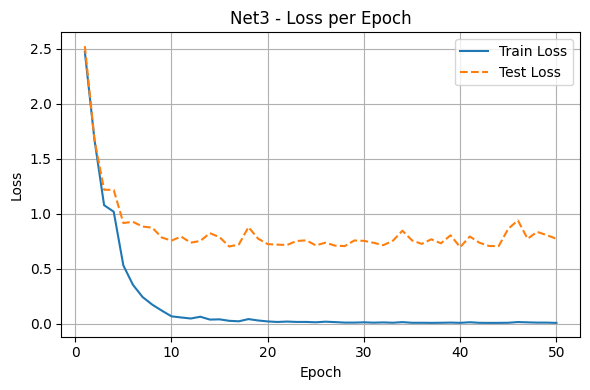

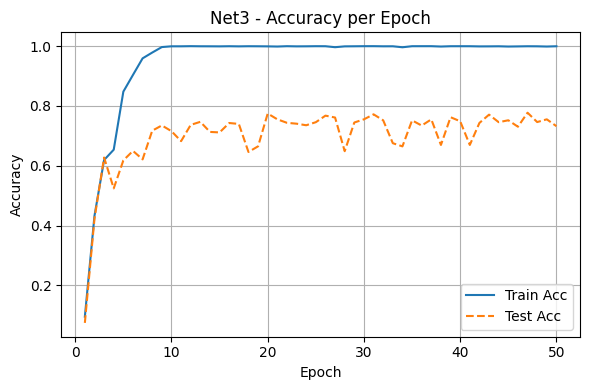

In [72]:
# Plot a train & test loss per epoch graph for Net3
plt.figure(figsize=(6, 4))
epochs = np.arange(1, len(history['train_loss']) + 1)
plt.plot(epochs, history['train_loss'], label='Train Loss', linestyle='-')
plt.plot(epochs, history['val_loss'], label='Test Loss', linestyle='--')
plt.title('Net3 - Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot a train & test accuracy per epoch graph for Net3
plt.figure(figsize=(6, 4))
epochs = np.arange(1, len(history['train_acc']) + 1)
plt.plot(epochs, history['train_acc'], label='Train Acc', linestyle='-')
plt.plot(epochs, history['val_acc'], label='Test Acc', linestyle='--')
plt.title('Net3 - Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# **Compute Metrics**

In [73]:
# Compute precision, recall, F1-score and confusion matrix of the model over the given data loader
@torch.no_grad()
def calculate_metrics(model, loader, loss_fn, device):
  # Set model to eval mode
  model.eval()

  # Precision, recall, F1-score and confusion matrix accumulators
  prec_metric = MulticlassPrecision(num_classes=10, average='macro').to(device)
  rec_metric = MulticlassRecall(num_classes=10, average='macro').to(device)
  f1_metric = MulticlassF1Score(num_classes=10, average='macro').to(device)
  cm_metric = MulticlassConfusionMatrix(num_classes=10).to(device)

  # Iterate through each batch
  for batch in loader:
    # Unpack batch into images and labels
    imgs, labels = batch
    imgs, labels = imgs.to(device), labels.to(device)

    # Model predictions and predicted classes
    outputs = model(imgs)
    _, preds = torch.max(outputs, dim=1)

    # Update all metrics with current batch
    prec_metric.update(preds, labels)
    rec_metric.update(preds, labels)
    f1_metric.update(preds, labels)
    cm_metric.update(preds, labels)

  # Compute final metrics across entire data loader
  prec = prec_metric.compute().item()
  rec  = rec_metric.compute().item()
  f1   = f1_metric.compute().item()
  cm   = cm_metric.compute()

  return prec, rec, f1, cm

In [74]:
# Plot a confusion matrix
def plot_confusion_matrix(cm, class_names):
  # Convert the confusion matrix from tensor to numpy
  cm = cm.cpu().numpy()

  # Plot the confusion matrix
  plt.figure(figsize=(6, 6))
  sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names, cbar=True, square=True)
  plt.xlabel('Predicted label')
  plt.ylabel('True label')
  plt.title('Confusion Matrix')
  plt.tight_layout()
  plt.show()

Precision (macro): 0.6437
Recall (macro): 0.6573
F1-score (macro): 0.6350


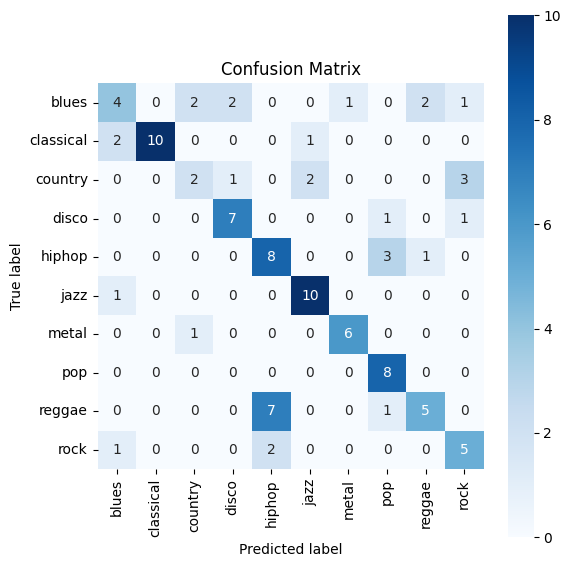

In [75]:
# Calculate precision, recall, F1-score and confusion matrix of Net3 over the test set
prec, rec, f1, cm = calculate_metrics(model, test_loader, loss_fn, device)

# Print the precision, recall and F1-score
print(f'Precision (macro): {prec:.4f}')
print(f'Recall (macro): {rec:.4f}')
print(f'F1-score (macro): {f1:.4f}')

# Plot the confusion matrix
plot_confusion_matrix(cm, test_loader.dataset.dataset.classes)

In [76]:
# End comet experiment
experiment.end()

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     name                  : residential_guava_224
COMET INFO:     url                   : https://www.comet.com/davidafshepherd/music-genre-classification/d91838756e214762b98511614d415b65
COMET INFO:   Others:
COMET INFO:     notebook_url : https://colab.research.google.com/notebook#fileId=1nt3Aj9SW4EnkYeO7O8R5FAG0PrOFEGvr
COMET INFO:   Uploads:
COMET INFO:     environment details : 1
COMET INFO:     filename            : 1
COMET INFO:     installed packages  : 1
COMET INFO:     model graph         : 1
COMET INFO:     notebook            : 2
COMET INFO:     os packages         : 1
COMET INFO:     source_code         : 1
COMET INFO: 
